# Converting a Keras model to a spiking neural network

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/keras-to-snn.ipynb)

A key feature of NengoDL is the ability to convert non-spiking networks into spiking
networks. We can build both spiking and non-spiking networks in NengoDL, but often we
may have an existing non-spiking network defined in a framework like Keras that we want
to convert to a spiking network. The [NengoDL
Converter](https://www.nengo.ai/nengo-dl/converter.html) is designed to assist in that
kind of translation. By default, the converter takes in a Keras model and outputs an
exactly equivalent Nengo network (so the Nengo network will be non-spiking). However,
the converter can also apply various transformations during this conversion process, in
particular aimed at converting a non-spiking Keras model into a spiking Nengo model.

The goal of this notebook is to familiarize you with the process of converting a Keras
network to a spiking neural network. Swapping to spiking neurons is a significant change
to a model, which will have far-reaching impacts on the model's behaviour; we cannot
simply change the neuron type and expect the model to perform the same without making
any other changes to the model. This example will walk through some steps to take to
help tune a spiking model to more closely match the performance of the original
non-spiking network.

In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf

import nengo_dl

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In this example we'll use the standard [MNIST
dataset](http://yann.lecun.com/exdb/mnist/).

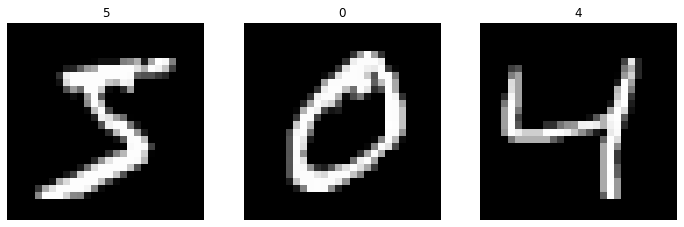

In [2]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i, 0, 0]))

## Converting a Keras model to a Nengo network

Next we'll build a simple convolutional network. This architecture is chosen to be a
quick and easy solution for this task; other tasks would likely require a different
architecture, but the same general principles will apply.

In [3]:
# input
inp = tf.keras.Input(shape=(28, 28, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(conv0)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=10)(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)

Once the Keras model is created, we can pass it into the NengoDL Converter. The
Converter tool is designed to automate the translation from Keras to Nengo as much as
possible. You can see the full list of arguments the Converter accepts in the
[documentation](https://www.nengo.ai/nengo-dl/reference.html?highlight=converter#nengo_dl.Converter).

In [4]:
converter = nengo_dl.Converter(model)

Now we are ready to train the network. It's important to note that we are using standard
(non-spiking) ReLU neurons at this point.

To make this example run a bit more quickly we've provided some pre-trained weights that
will be downloaded below; set `do_training=True` to run the training yourself.

In [5]:
do_training = False
if do_training:
    with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.Adam(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[inp]: train_images},
            {converter.outputs[dense]: train_labels},
            validation_data=(
                {converter.inputs[inp]: test_images},
                {converter.outputs[dense]: test_labels},
            ),
            epochs=2,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1lBkR968AQo__t8sMMeDYGTQpBJZIs2_T",
        "keras_to_snn_params.npz",
    )
    print("Loaded pretrained weights")

Loaded pretrained weights


After training for 2 epochs the non-spiking network is achieving ~98% accuracy on the
test data, which is what we'd expect for a network this simple.

Now that we have our trained weights, we can begin the conversion to spiking neurons. To
help us in this process we're going to first define a helper function that will build
the network for us, load weights from a specified file, and make it easy to play around
with some other features of the network.

In [6]:
def run_network(
    activation,
    params_file="keras_to_snn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    # plot the results
    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[ii, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv0_probe][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            "Neural activities (conv0 mean=%dHz max=%dHz)" % (rates.mean(), rates.max())
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

Now to run our trained network all we have to do is:

Test accuracy: 98.25%


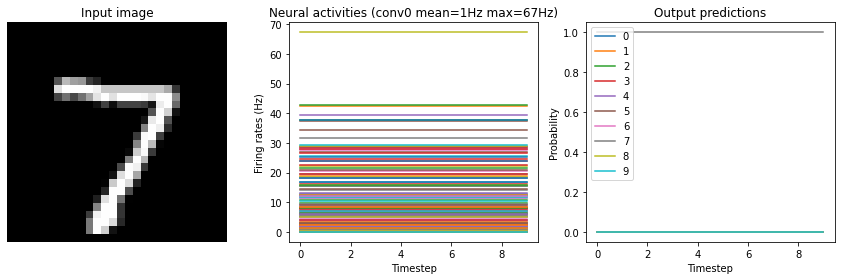

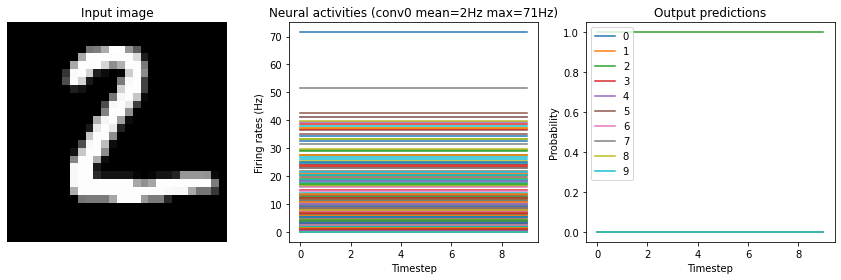

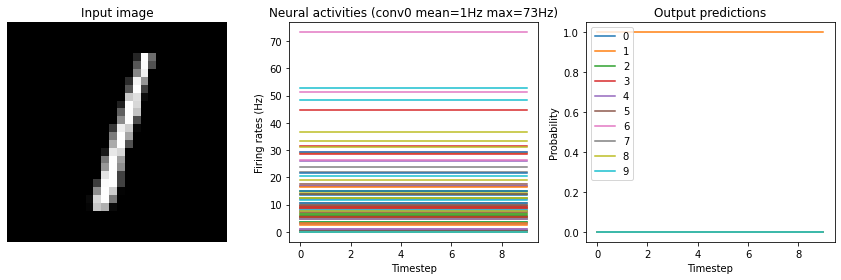

In [7]:
run_network(activation=nengo.RectifiedLinear(), n_steps=10)

Note that we're plotting the output over time for consistency with future plots, but
since our network doesn't have any temporal elements (e.g. spiking neurons), the output
is constant for each digit.

## Converting to a spiking neural network

Now that we have the non-spiking version working in Nengo, we can start converting the
network into spikes. Using the NengoDL converter, we can swap all the `relu` activation
functions to `nengo.SpikingRectifiedLinear`.

Test accuracy: 20.75%


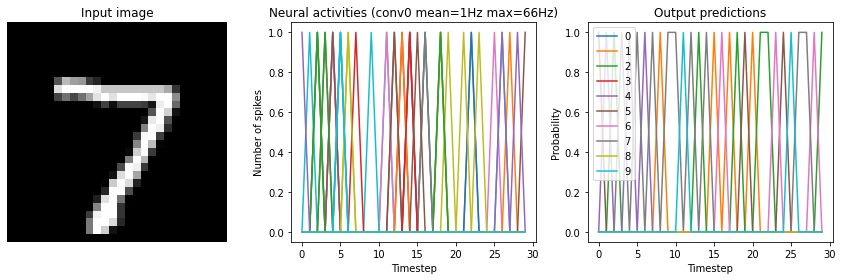

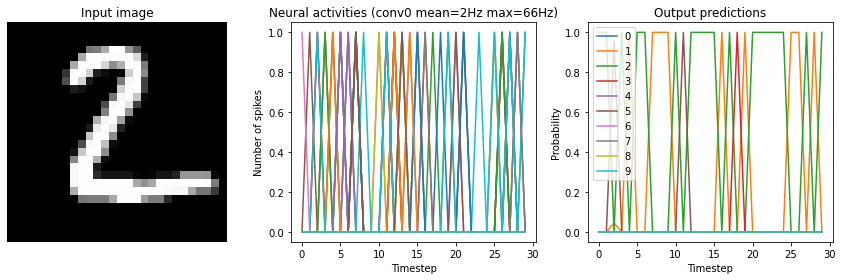

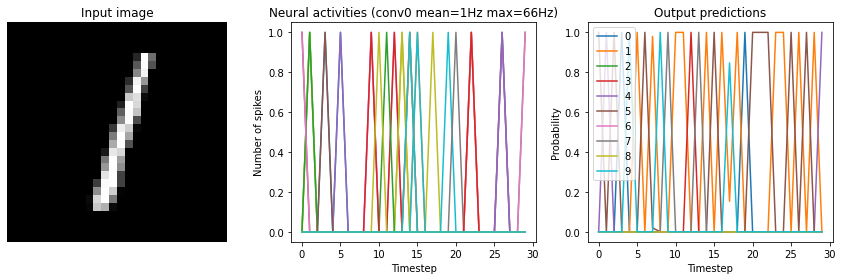

In [8]:
run_network(activation=nengo.SpikingRectifiedLinear())

In this naive conversion we are getting quite low accuracy.
Next, we will look at various steps we can take to
improve the performance of the spiking model.

### Synaptic smoothing

As we can see in the output prediction plots, the network output is very noisy.
Spikes are discrete events that exist for only a single time step and then disappear; we
can see the literal "spikes" in the plots. Even if the neuron corresponding to the
correct output is spiking quite rapidly, it's still not guaranteed that it will spike on
exactly the last timestep (which is when we are checking the test accuracy).

One way that we can compensate for this rapid fluctuation in the network output is to
apply some smoothing to the spikes. This can be achieved in Nengo through the use of
synaptic filters. The default `synapse` used in Nengo is a low-pass filter, and when we
specify a value for the `synapse` parameter, that value is used as the low-pass filter
time constant. When we pass a `synapse` value in the `run_network` function, it will
create a low-pass filter with that time constant on the output of all the spiking
neurons.

Intuitively, we can think of this as computing a running average of each neuron's
activity over a short window of time (rather than just looking at the spikes on the last
timestep).

Below we show results from the network running with three different low-pass filters.
Note that adding synaptic filters means that the network output takes longer to
settle (as the filters are making the output less responsive to rapid changes
in the input). So we'll run the network for longer in these tests.

Synapse=0.001


Test accuracy: 23.00%


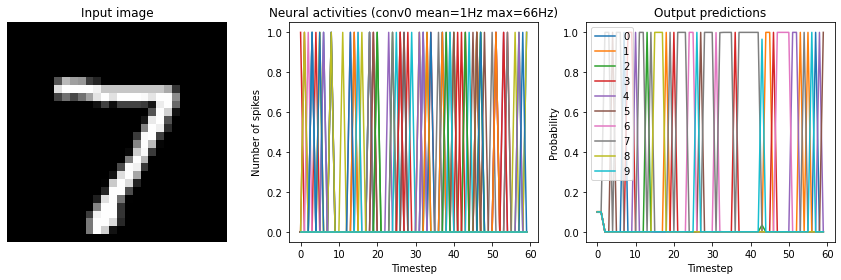

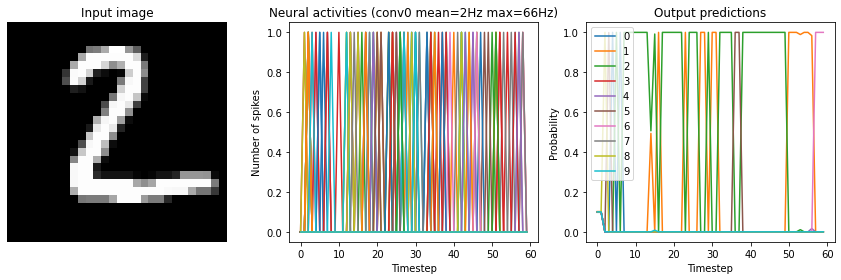

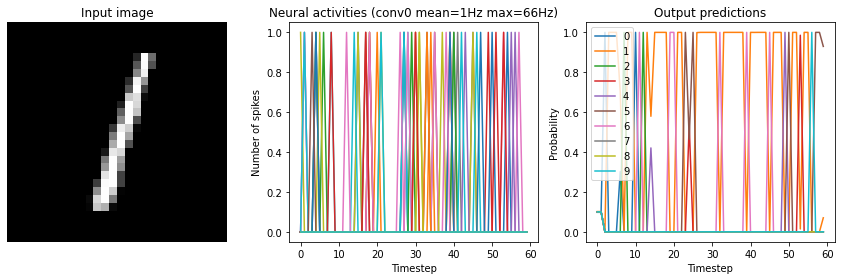

Synapse=0.005


Test accuracy: 52.25%


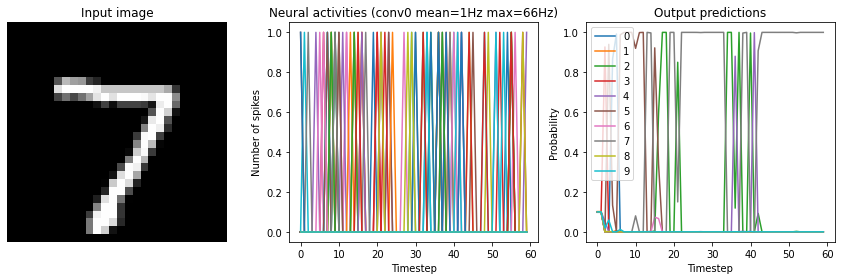

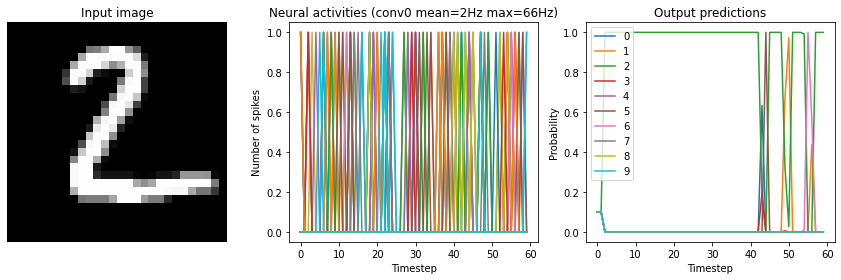

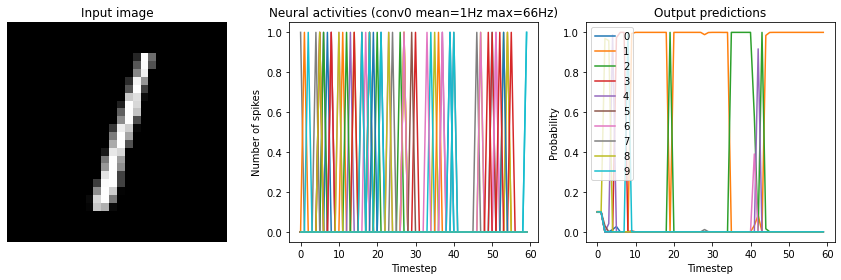

Synapse=0.010


Test accuracy: 71.75%


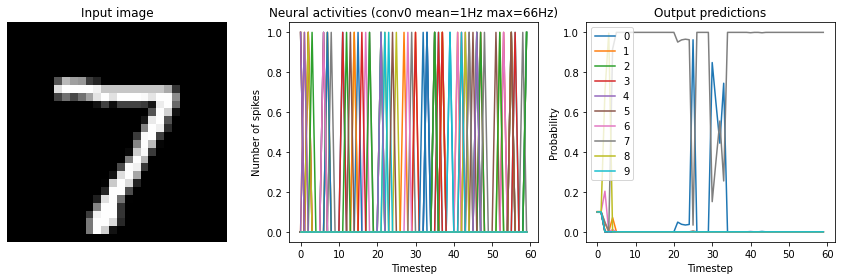

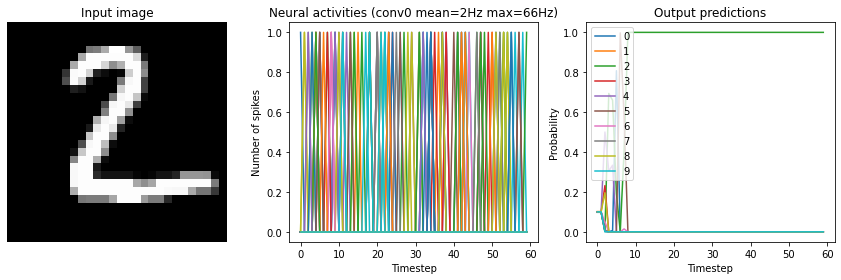

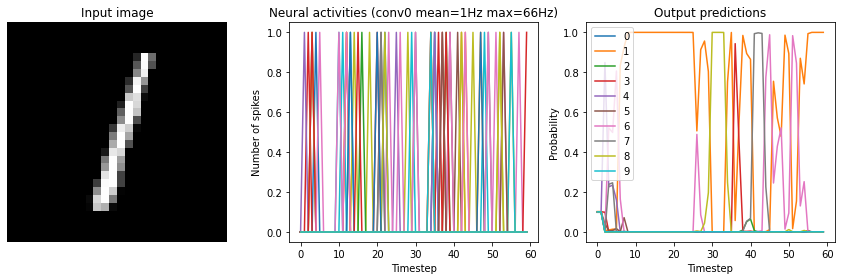

In [9]:
for s in [0.001, 0.005, 0.01]:
    print("Synapse=%.3f" % s)
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=s,
    )
    plt.show()

We can see that adding synaptic filtering smooths the output of the model and thereby
improves the accuracy. The accuracy is still not
great, but significantly better than what we started with.

However, as mentioned above, with more
synaptic filtering we have to present the input images for a longer period of time,
which takes longer to simulate and adds more latency to the model's predictions. This is
a common tradeoff in spiking networks (latency versus accuracy).
But it is important to keep in mind that this latency issue is exaggerated by the fact
that
we're processing a disconnected set of discrete inputs (images), rather than a
continuous stream of input data. In general, spiking neural networks are much better
suited for continuous time-series data, as then the internal state of the neurons and
synapses can continuously transition between inputs. But we're using discrete inputs in
this example as that is more typical in Keras models.

### Firing rates

Another way that we can improve network performance is by increasing the firing rates of
the neurons. Neurons that spike more frequently update their output signal more often.
This means that as firing rates increase, the behaviour of the spiking model will more
closely match the original non-spiking model (where the neuron is directly outputting
its true firing rate every timestep).

#### Post-training scaling

We can increase firing rates without retraining the model by applying a linear scale to
the input of all the neurons (and then dividing their output by the same scale factor).
Note that because we're applying a linear scale to the input and output, this will
likely only work well with linear activation functions (like ReLU). To apply this
scaling using the NengoDL Converter, we can use the `scale_firing_rates` parameter.

Scale=2


Test accuracy: 80.25%


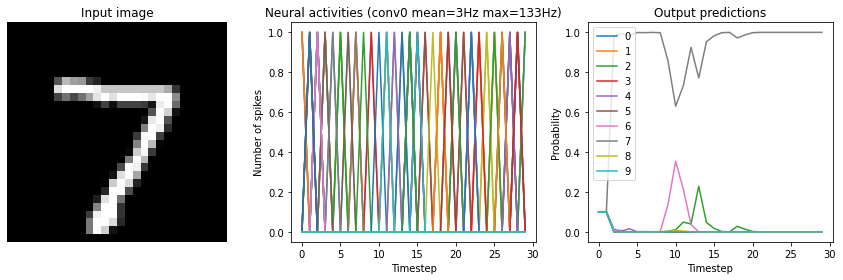

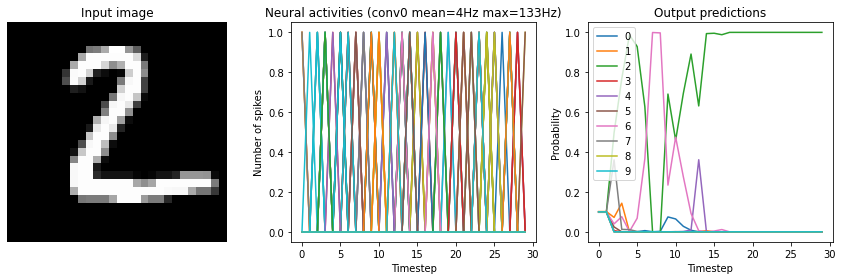

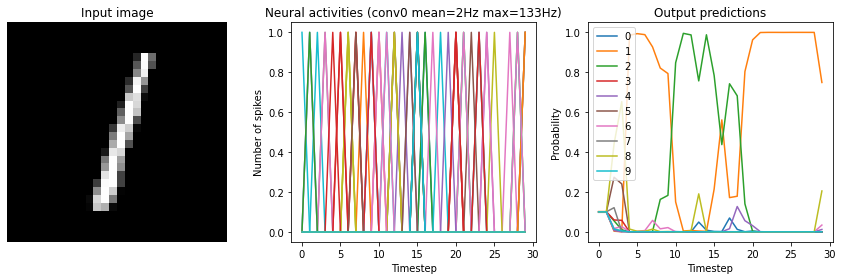

Scale=5


Test accuracy: 96.00%


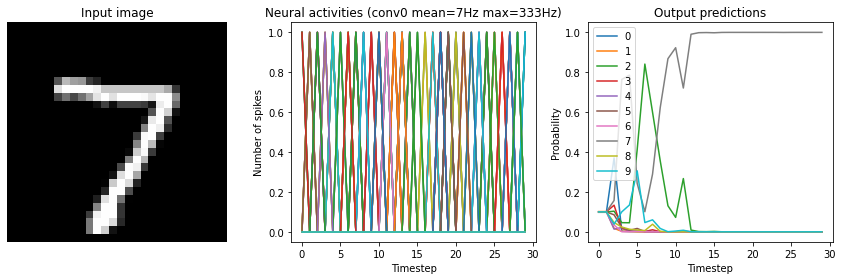

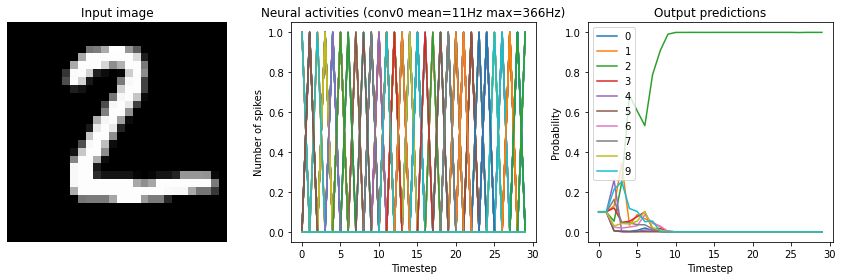

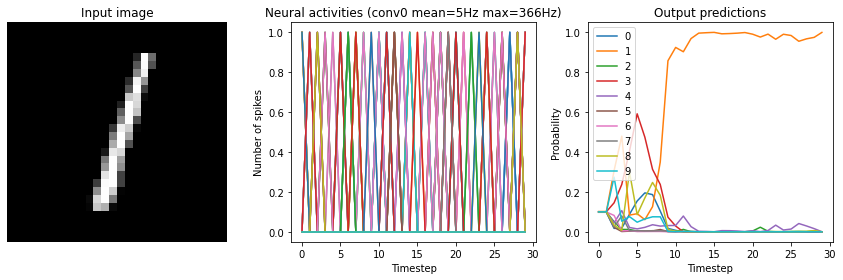

Scale=10


Test accuracy: 98.25%


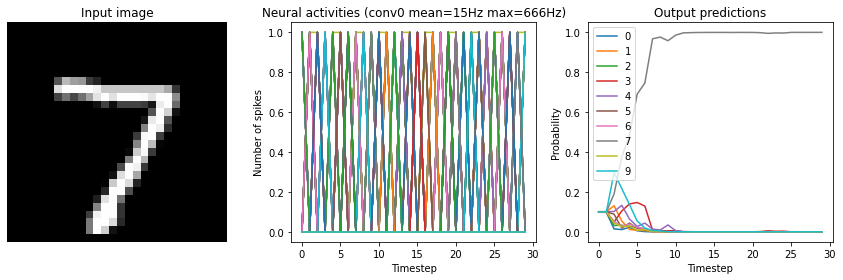

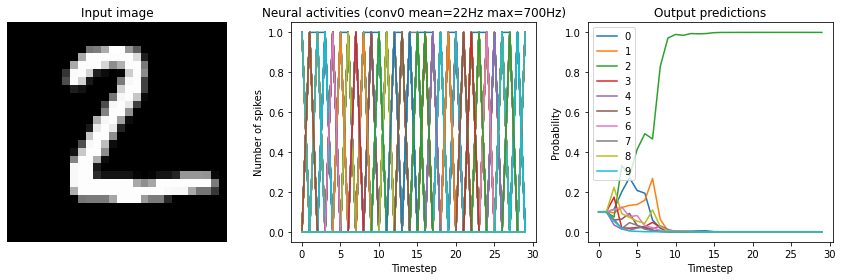

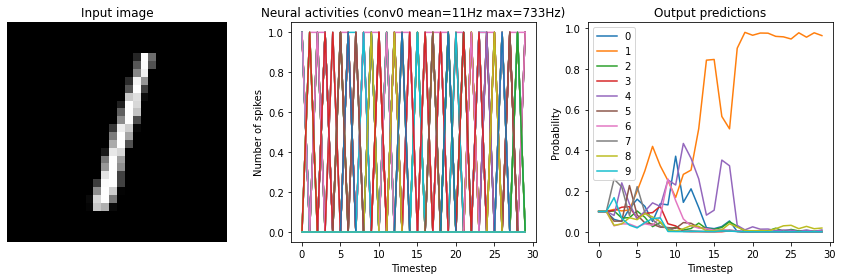

In [10]:
for scale in [2, 5, 10]:
    print("Scale=%d" % scale)
    run_network(
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
        synapse=0.01,
    )
    plt.show()

We can see that as the frequency of spiking increases, the accuracy also increases. And
we're able to achieve good accuracy (very close to the original non-spiking network)
without adding too much latency.

Note that if we increase the firing rates enough, the spiking model eventually becomes
equivalent to a non-spiking model:

Test accuracy: 98.25%


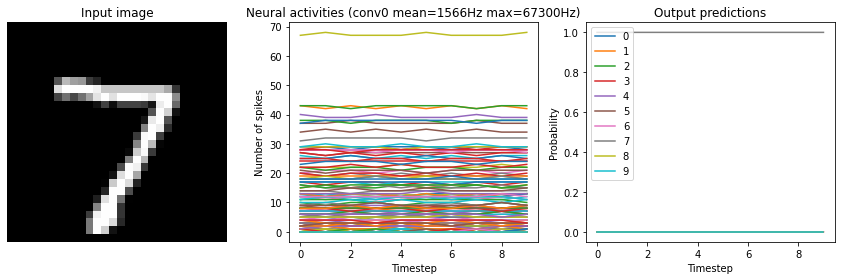

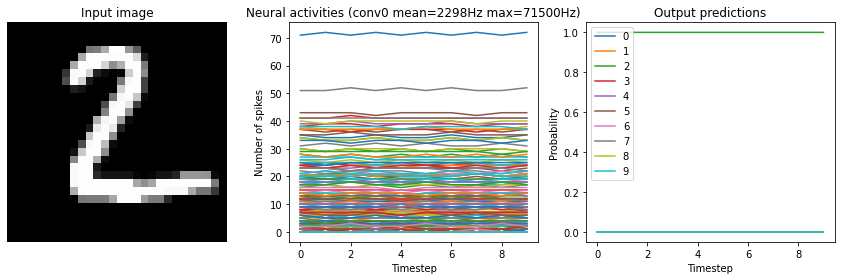

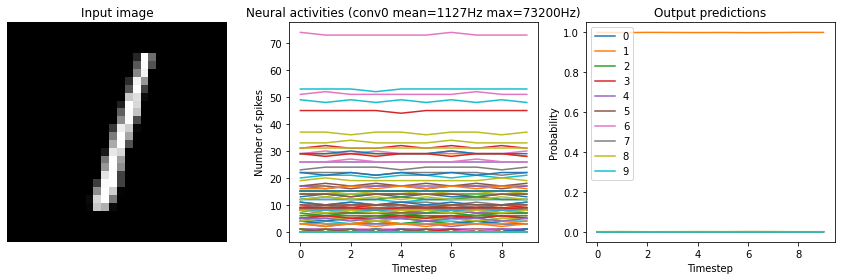

In [11]:
run_network(
    activation=nengo.SpikingRectifiedLinear(), scale_firing_rates=1000, n_steps=10
)

While this looks good from an accuracy perspective, it also means that we have lost many
of the advantages of a spiking model (e.g. sparse communication, as indicated by the
very high firing rates). This is another common tradeoff (accuracy versus firing rates)
that can be customized depending on the demands of a particular application.

#### Regularizing during training

Rather than using `scale_firing_rates` to upscale the firing rates after training, we
can also directly optimize the firing rates during training. We'll add loss functions
that compute the mean squared error (MSE) between the output activity of each of the
convolutional layers and some target firing rates we specify. We can think of this as
applying L2 regularization to the firing rates, but we've shifted the regularization
point from 0 to some target value.  One of the benefits of this method is that it is
also effective for neurons with non-linear activation functions, such as LIF neurons.

In [12]:
# we'll encourage the neurons to spike at around 250Hz
target_rate = 250

# convert keras model to nengo network
converter = nengo_dl.Converter(model)

# add probes to the convolutional layers, which
# we'll use to apply the firing rate regularization
with converter.net:
    output_p = converter.outputs[dense]
    conv0_p = nengo.Probe(converter.layers[conv0])
    conv1_p = nengo.Probe(converter.layers[conv1])

with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    # add regularization loss functions to the convolutional layers
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={
            output_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            conv0_p: tf.losses.mse,
            conv1_p: tf.losses.mse,
        },
        loss_weights={output_p: 1, conv0_p: 1e-3, conv1_p: 1e-3},
    )

    do_training = False
    if do_training:
        # run training (specifying the target rates for the convolutional layers)
        sim.fit(
            {converter.inputs[inp]: train_images},
            {
                output_p: train_labels,
                conv0_p: np.ones((train_labels.shape[0], 1, conv0_p.size_in))
                * target_rate,
                conv1_p: np.ones((train_labels.shape[0], 1, conv1_p.size_in))
                * target_rate,
            },
            epochs=10,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_regularized_params")
    else:
        # download pretrained weights
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1xvIIIQjiA4UM9Mg_4rq_ttBH3wIl0lJx",
            "keras_to_snn_regularized_params.npz",
        )
        print("Loaded pretrained weights")

|                     Building network (0%)                    | ETA:  --:--:--

|                     Building network (0%)                    | ETA:  --:--:--

|###                   Building network (4%)                     | ETA: 0:00:03

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (44%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Loaded pretrained weights


Now we can examine the firing rates in the non-spiking network.

Test accuracy: 98.50%


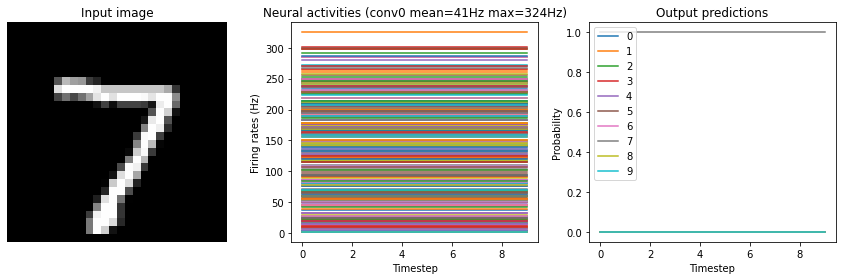

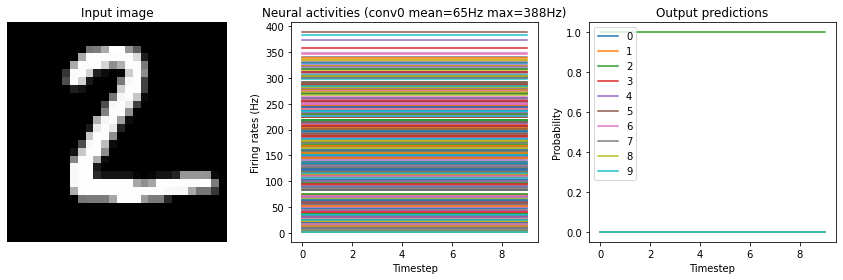

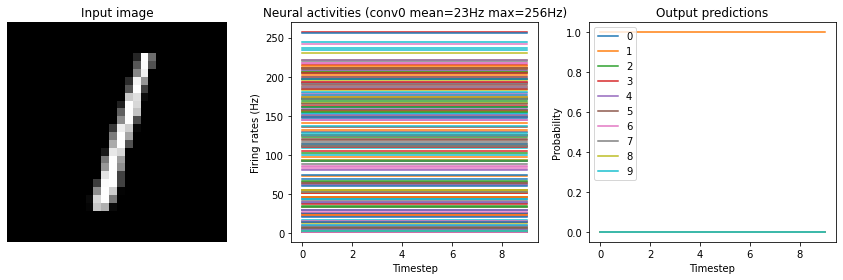

In [13]:
run_network(
    activation=nengo.RectifiedLinear(),
    params_file="keras_to_snn_regularized_params",
    n_steps=10,
)

In the neuron activity plot we can see that the firing rates are around the magnitude we
specified (we could adjust the regularization function/weighting to refine this
further). Now we can convert it to spiking neurons, without applying any scaling.

Test accuracy: 98.25%


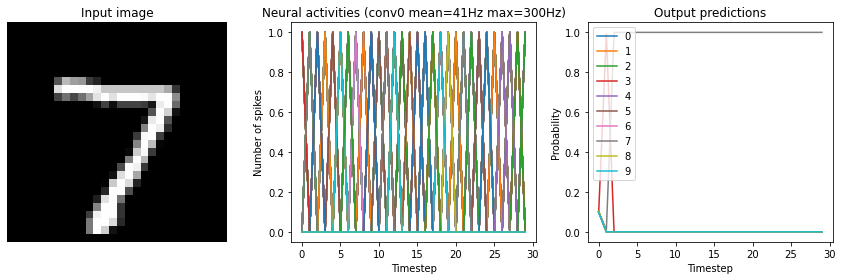

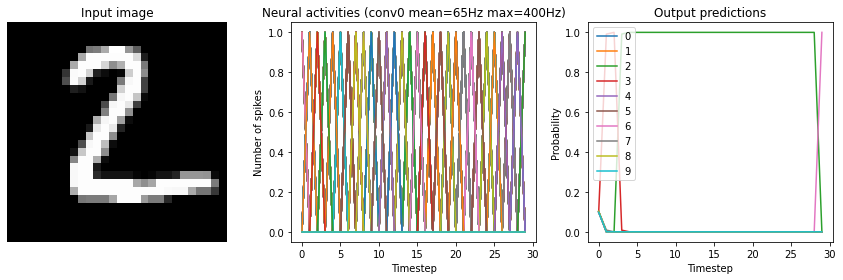

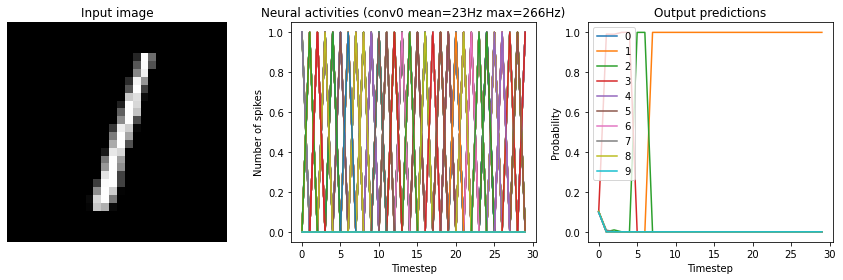

In [14]:
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    params_file="keras_to_snn_regularized_params",
    synapse=0.01,
)

We can see that this network, because we trained it with spiking neurons in mind, can be
converted to a spiking network without losing much performance or requiring any further
tweaking.

## Conclusions

In this example we've gone over the process of converting a non-spiking Keras model to a
spiking Nengo network. We've shown some of the common issues that crop up, and how to go
about diagnosing/addressing them. In particular, we looked at
synaptic filtering and firing rates, and how adjusting those factors can affect various
properties of the model (such as accuracy, latency, and temporal sparsity).  Note that a
lot of these factors represent tradeoffs that are application dependent. The particular
parameters that we used in this example may not work or make sense in other
applications, but this same workflow and thought process should apply to converting any
kind of network to a spiking Nengo model.